In [1]:
import torch.nn.functional

from model import UNet
from lfw_dataset import LFWDataset
from torch.utils.data.dataloader import DataLoader
import numpy as np
from torchvision.transforms import v2
import cv2
import matplotlib.pyplot as plt
from utils import transform_generator, inv_transform
from copy import deepcopy
import pickle
from utils import eval
from train import train
import wandb

/home/georgerapeanu/anaconda3/envs/AI2/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/georgerapeanu/anaconda3/envs/AI2/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please

In [2]:
sweep_config = {
    'method': 'grid'
    }
metric = {
    'name': 'val_loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'NUM_EPOCHS': {
        'values': [10]
    },
     'BATCH_SIZE': {
         'values': [32, 48, 64, 80, 96]
      },
    'INPUT_SHAPE': {
        'values': [(64, 64)]
    },
    'NUM_LAYERS': {
        'values': [2]
    },
    'LR': {
        'values': [0.004, 0.008, 0.01]
      },
    'INTERMEDIARY_FILTERS': {
        'values': [8]
    }
}

# parameters_dict = {
#     'NUM_EPOCHS': {
#         'values': [10, 20]
#     },
#      'BATCH_SIZE': {
#         # integers between 32 and 256
#         # with evenly-distributed logarithms 
#         'distribution': 'q_log_uniform_values',
#         'q': 8,
#         'min': 32,
#         'max': 96,
#       },
#     'INPUT_SHAPE': {
#         'values': [(64, 64)]
#     },
#     'NUM_LAYERS': {
#         'values': [1, 2]
#     },
#     'LR': {
#         # a flat distribution between 0 and 0.1
#         'distribution': 'uniform',
#         'min': 0.004,
#         'max': 0.04
#       },
#     'INTERMEDIARY_FILTERS': {
#         'values': [8, 16, 32]
#     }
# }

sweep_config['parameters'] = parameters_dict

In [3]:
sweep_id = wandb.sweep(sweep_config, project="cvdl")

Create sweep with ID: cstsi9oz
Sweep URL: https://wandb.ai/georgerapeanu/cvdl/sweeps/cstsi9oz


In [4]:
def run_wandb():
    with wandb.init():
        train(None, wandb.config)

In [5]:
wandb.agent(sweep_id, run_wandb, project="cvdl")RuntimeError: Can't redefine method: forward on class: __torch__.model.___torch_mangle_35.UNet (of Python compilation unit at: 0x5638a008b5a0)

wandb: Agent Starting Run: 11fx438a with config:
wandb: 	BATCH_SIZE: 32
wandb: 	INPUT_SHAPE: [64, 64]
wandb: 	INTERMEDIARY_FILTERS: 8
wandb: 	LR: 0.004
wandb: 	NUM_EPOCHS: 10
wandb: 	NUM_LAYERS: 2
wandb: Currently logged in as: georgerapeanu. Use `wandb login --relogin` to force relogin


Epoch [1/10], Train Loss: 0.5774, Validation Loss: 0.6068
Epoch [2/10], Train Loss: 0.3522, Validation Loss: 0.4068
Epoch [3/10], Train Loss: 0.3033, Validation Loss: 0.3795
Epoch [4/10], Train Loss: 0.2689, Validation Loss: 0.4470
Epoch [5/10], Train Loss: 0.2437, Validation Loss: 0.2421
Epoch [6/10], Train Loss: 0.2187, Validation Loss: 0.2265
Epoch [7/10], Train Loss: 0.2090, Validation Loss: 0.2215
Epoch [8/10], Train Loss: 0.2006, Validation Loss: 0.2214
Epoch [9/10], Train Loss: 0.1895, Validation Loss: 0.3020
Epoch [10/10], Train Loss: 0.1906, Validation Loss: 0.2043


fw_intersection_over_union,▁▆▆▅▇███▇█
mean_intersection_over_union,▁▅▅▄▇███▇█
mean_pixel_accuracy,▁▅▆▅▇██▇▇█
train_loss,█▄▃▂▂▂▁▁▁▁
val_loss,█▅▄▅▂▁▁▁▃▁
fw_intersection_over_union,0.87038
mean_intersection_over_union,0.78342
mean_pixel_accuracy,0.85686
train_loss,0.19059
val_loss,0.20431


wandb: Agent Starting Run: 7hcvt7e5 with config:
wandb: 	BATCH_SIZE: 48
wandb: 	INPUT_SHAPE: [64, 64]
wandb: 	INTERMEDIARY_FILTERS: 8
wandb: 	LR: 0.004
wandb: 	NUM_EPOCHS: 10
wandb: 	NUM_LAYERS: 2


Epoch [1/10], Train Loss: 0.6239, Validation Loss: 0.4148
Epoch [2/10], Train Loss: 0.3762, Validation Loss: 0.3373
Epoch [3/10], Train Loss: 0.3104, Validation Loss: 0.2929
Epoch [4/10], Train Loss: 0.2697, Validation Loss: 0.2644
Epoch [5/10], Train Loss: 0.2479, Validation Loss: 0.2728
Epoch [6/10], Train Loss: 0.2303, Validation Loss: 0.2353
Epoch [7/10], Train Loss: 0.2201, Validation Loss: 0.2342
Epoch [8/10], Train Loss: 0.2097, Validation Loss: 0.2396
Epoch [9/10], Train Loss: 0.2043, Validation Loss: 0.2086
Epoch [10/10], Train Loss: 0.1936, Validation Loss: 0.2133


fw_intersection_over_union,▁▄▆▆▆▇▇▇██
mean_intersection_over_union,▁▄▆▆▆▇▇▇██
mean_pixel_accuracy,▁▅▆▇▇▇▇▆██
train_loss,█▄▃▂▂▂▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▁▁
fw_intersection_over_union,0.86531
mean_intersection_over_union,0.77499
mean_pixel_accuracy,0.84295
train_loss,0.19357
val_loss,0.21333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wo5w8r0r with config:
wandb: 	BATCH_SIZE: 48
wandb: 	INPUT_SHAPE: [64, 64]
wandb: 	INTERMEDIARY_FILTERS: 8
wandb: 	LR: 0.01
wandb: 	NUM_EPOCHS: 10
wandb: 	NUM_LAYERS: 2


Epoch [1/10], Train Loss: 0.5946, Validation Loss: 0.5919
Epoch [2/10], Train Loss: 0.3648, Validation Loss: 0.6994
Epoch [3/10], Train Loss: 0.3239, Validation Loss: 0.3574
Epoch [4/10], Train Loss: 0.2919, Validation Loss: 0.3064
Epoch [5/10], Train Loss: 0.2738, Validation Loss: 0.2647
Epoch [6/10], Train Loss: 0.2523, Validation Loss: 0.2643
Epoch [7/10], Train Loss: 0.2448, Validation Loss: 0.2804
Epoch [8/10], Train Loss: 0.2341, Validation Loss: 0.2543
Epoch [9/10], Train Loss: 0.2228, Validation Loss: 0.2263
Epoch [10/10], Train Loss: 0.2140, Validation Loss: 0.2255


fw_intersection_over_union,▂▁▆▇▇█▇███
mean_intersection_over_union,▂▁▆▇▇█▇███
mean_pixel_accuracy,▂▁▆▇▇█████
train_loss,█▄▃▂▂▂▂▁▁▁
val_loss,▆█▃▂▂▂▂▁▁▁
fw_intersection_over_union,0.85509
mean_intersection_over_union,0.76054
mean_pixel_accuracy,0.83653
train_loss,0.214
val_loss,0.22551


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bd33oyyp with config:
wandb: 	BATCH_SIZE: 64
wandb: 	INPUT_SHAPE: [64, 64]
wandb: 	INTERMEDIARY_FILTERS: 8
wandb: 	LR: 0.008
wandb: 	NUM_EPOCHS: 10
wandb: 	NUM_LAYERS: 2


Epoch [1/10], Train Loss: 0.8109, Validation Loss: 0.5202
Epoch [2/10], Train Loss: 0.4179, Validation Loss: 0.3507
Epoch [3/10], Train Loss: 0.3136, Validation Loss: 0.3134
Epoch [4/10], Train Loss: 0.2823, Validation Loss: 0.2712
Epoch [5/10], Train Loss: 0.2675, Validation Loss: 0.2614
Epoch [6/10], Train Loss: 0.2466, Validation Loss: 0.2518
Epoch [7/10], Train Loss: 0.2391, Validation Loss: 0.2570
Epoch [8/10], Train Loss: 0.2283, Validation Loss: 0.2429
Epoch [9/10], Train Loss: 0.2252, Validation Loss: 0.2995
Epoch [10/10], Train Loss: 0.2330, Validation Loss: 0.2372


fw_intersection_over_union,▁▄▅▇▇▇▇█▅█
mean_intersection_over_union,▁▄▅▆▇▇▇▇▅█
mean_pixel_accuracy,▁▄▄▆▇▆▇▇▄█
train_loss,█▃▂▂▂▁▁▁▁▁
val_loss,█▄▃▂▂▁▁▁▃▁
fw_intersection_over_union,0.85263
mean_intersection_over_union,0.75299
mean_pixel_accuracy,0.83342
train_loss,0.233
val_loss,0.23722


wandb: Agent Starting Run: cyiw19sq with config:
wandb: 	BATCH_SIZE: 80
wandb: 	INPUT_SHAPE: [64, 64]
wandb: 	INTERMEDIARY_FILTERS: 8
wandb: 	LR: 0.008
wandb: 	NUM_EPOCHS: 10
wandb: 	NUM_LAYERS: 2


Epoch [1/10], Train Loss: 0.8336, Validation Loss: 0.6595
Epoch [2/10], Train Loss: 0.5812, Validation Loss: 0.5108
Epoch [3/10], Train Loss: 0.4405, Validation Loss: 0.4378
Epoch [4/10], Train Loss: 0.3513, Validation Loss: 0.4145
Epoch [5/10], Train Loss: 0.3005, Validation Loss: 0.2942
Epoch [6/10], Train Loss: 0.2739, Validation Loss: 0.2843
Epoch [7/10], Train Loss: 0.2560, Validation Loss: 0.2555
Epoch [8/10], Train Loss: 0.2417, Validation Loss: 0.2773
Epoch [9/10], Train Loss: 0.2293, Validation Loss: 0.2492
Epoch [10/10], Train Loss: 0.2200, Validation Loss: 0.2371


fw_intersection_over_union,▁▃▅▅▇▇▇▇██
mean_intersection_over_union,▁▂▅▅▇▇█▇██
mean_pixel_accuracy,▁▃▅▆▇▇▇▇██
train_loss,█▅▄▂▂▂▁▁▁▁
val_loss,█▆▄▄▂▂▁▂▁▁
fw_intersection_over_union,0.85687
mean_intersection_over_union,0.76353
mean_pixel_accuracy,0.84414
train_loss,0.21997
val_loss,0.23712


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ojflc06d with config:
wandb: 	BATCH_SIZE: 96
wandb: 	INPUT_SHAPE: [64, 64]
wandb: 	INTERMEDIARY_FILTERS: 8
wandb: 	LR: 0.004
wandb: 	NUM_EPOCHS: 10
wandb: 	NUM_LAYERS: 2


Epoch [1/10], Train Loss: 0.7762, Validation Loss: 0.7307
Epoch [2/10], Train Loss: 0.5292, Validation Loss: 0.4627
Epoch [3/10], Train Loss: 0.4017, Validation Loss: 0.3957
Epoch [4/10], Train Loss: 0.3258, Validation Loss: 0.3866
Epoch [5/10], Train Loss: 0.2806, Validation Loss: 0.2911
Epoch [6/10], Train Loss: 0.2531, Validation Loss: 0.2532
Epoch [7/10], Train Loss: 0.2364, Validation Loss: 0.2533
Epoch [8/10], Train Loss: 0.2207, Validation Loss: 0.2292
Epoch [9/10], Train Loss: 0.2144, Validation Loss: 0.2435
Epoch [10/10], Train Loss: 0.2060, Validation Loss: 0.2201


fw_intersection_over_union,▁▆▆▆▇█████
mean_intersection_over_union,▁▆▆▆▇█████
mean_pixel_accuracy,▁▆▆▆▇▇██▇█
train_loss,█▅▃▂▂▂▁▁▁▁
val_loss,█▄▃▃▂▁▁▁▁▁
fw_intersection_over_union,0.86451
mean_intersection_over_union,0.77601
mean_pixel_accuracy,0.84964
train_loss,0.20595
val_loss,0.22015


wandb: Agent Starting Run: 9z7y3jmd with config:
wandb: 	BATCH_SIZE: 96
wandb: 	INPUT_SHAPE: [64, 64]
wandb: 	INTERMEDIARY_FILTERS: 8
wandb: 	LR: 0.01
wandb: 	NUM_EPOCHS: 10
wandb: 	NUM_LAYERS: 2


Epoch [1/10], Train Loss: 0.6302, Validation Loss: 0.5812
Epoch [2/10], Train Loss: 0.4369, Validation Loss: 0.4429
Epoch [3/10], Train Loss: 0.3798, Validation Loss: 0.4213
Epoch [4/10], Train Loss: 0.3360, Validation Loss: 0.3733
Epoch [5/10], Train Loss: 0.3039, Validation Loss: 0.3295
Epoch [6/10], Train Loss: 0.2746, Validation Loss: 0.4610
Epoch [7/10], Train Loss: 0.2601, Validation Loss: 0.3150
Epoch [8/10], Train Loss: 0.2454, Validation Loss: 0.3667
Epoch [9/10], Train Loss: 0.2370, Validation Loss: 0.2506
Epoch [10/10], Train Loss: 0.2290, Validation Loss: 0.2477


fw_intersection_over_union,▁▃▃▆▆▃▆▅██
mean_intersection_over_union,▁▂▂▆▇▃▆▅██
mean_pixel_accuracy,▁▂▁▆█▄▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_loss,█▅▅▄▃▅▂▃▁▁
fw_intersection_over_union,0.84495
mean_intersection_over_union,0.73738
mean_pixel_accuracy,0.80479
train_loss,0.22895
val_loss,0.24771


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [2]:
wandb.init(
    # set the wandb project where this run will be logged
    project="cvdl",
    
    # track hyperparameters and run metadata
    config={
        'NUM_EPOCHS': 10,
        'BATCH_SIZE': 32,
        'INPUT_SHAPE': (64, 64),
        'NUM_LAYERS': 1,
        'LR': 0.0713
    }
)


wandb: Currently logged in as: georgerapeanu. Use `wandb login --relogin` to force relogin


In [3]:
wandb.config


{'NUM_EPOCHS': 10, 'BATCH_SIZE': 32, 'INPUT_SHAPE': [64, 64], 'NUM_LAYERS': 1, 'LR': 0.0713}

In [5]:
NUM_EPOCHS = 100
BATCH_SIZE= 128
INPUT_SHAPE = (64, 64)
NUM_LAYERS = 2
LR = 0.01

ARTIFACTS_PATH='./artifacts'
BASE_PATH="./lfw_dataset"

In [ ]:
train(None, wandb.config)

In [ ]:
wandb.finish()

In [7]:
ds = LFWDataset(BASE_PATH, transforms=transform_generator(INPUT_SHAPE), split_name='test', download=False)
model.eval()

X, y = ds[2]
model_y = model(X.view(-1, *X.shape))
model_y = torch.nn.functional.interpolate(model_y, size=tuple(y.shape))
model_y = model_y.view(-1, *y.shape).argmax(dim=0)

_, model_y = inv_transform(X, model_y)
X, y = inv_transform(X, y)

print(X.shape, y.shape, model_y.shape)
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(X, cmap='gray')
axes[0].set_title('Input')

axes[1].imshow(cv2.cvtColor(model_y, cv2.COLOR_BGR2RGB))
axes[1].set_title('Output')

axes[2].imshow(cv2.cvtColor(y, cv2.COLOR_BGR2RGB))
axes[2].set_title('Ground truth')

# Remove ticks and labels for a cleaner display
for ax in axes:
    ax.axis('off')

# Show the plot
plt.show()

KeyboardInterrupt: 

In [ ]:
eval(model, LFWDataset(BASE_PATH, transforms=transform_generator(INPUT_SHAPE), download=False, split_name='test'))

In [6]:
ds = LFWDataset(BASE_PATH, transforms=transform_generator(INPUT_SHAPE), split_name='test', download=False)

In [ ]:
len(ds)

In [8]:
ds[2][0].shape

torch.Size([3, 64, 64])

In [2]:
model = torch.load("./artifacts/model.h5", map_location=torch.device('cpu'))

In [3]:
model.eval()
scripted_model = torch.jit.script(model)
scripted_model.save("./artifacts/scripted_model.pt")

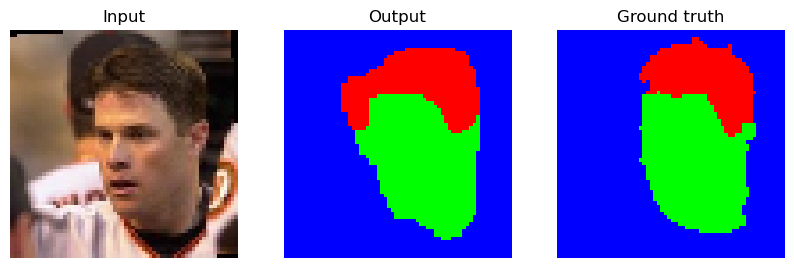

In [39]:
with torch.no_grad():
    model_y = model(ds[2][0].view(-1, *ds[2][0].shape))
    model_y = torch.nn.functional.interpolate(model_y, size=tuple(ds[2][0].shape[1:]))
    model_y = model_y.view(-1, *ds[2][1].shape).argmax(dim=0)
    X, model_y = inv_transform(ds[2][0], model_y)
    X, y = inv_transform(ds[2][0], ds[2][1])
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    
    axes[0].imshow(X)
    axes[0].set_title('Input')
    
    axes[1].imshow(cv2.cvtColor(model_y, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Output')
    
    axes[2].imshow(cv2.cvtColor(y, cv2.COLOR_BGR2RGB))
    axes[2].set_title('Ground truth')
    
    # Remove ticks and labels for a cleaner display
    for ax in axes:
        ax.axis('off')
    
    # Show the plot
    plt.show() 